In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)

In [26]:
results=p.map(ff, range(1,40),chunksize=1)

5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 14.804288


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)


(9119, 242) (9119,) (9119,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


6


(1, 829, 517) (60, 829, 517)


[0]	train-rmse:2.38198	valid-rmse:2.34033


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 15.133374


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


7


(1, 829, 517) (60, 829, 517)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1560


0


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 16.310143


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)


(9948, 242) (9948,) (9948,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[0]	train-rmse:2.37664	valid-rmse:2.32928


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)


(10777, 242) (10777,) (10777,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39155	valid-rmse:2.35013


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.721722	valid-rmse:0.71294


8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 17.574337


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[50]	train-rmse:0.721749	valid-rmse:0.711441


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1560


0


[50]	train-rmse:0.72169	valid-rmse:0.715336


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)


(11606, 242) (11606,) (11606,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40346	valid-rmse:2.36517


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.505962	valid-rmse:0.511124


[100]	train-rmse:0.504088	valid-rmse:0.512269


[100]	train-rmse:0.507281	valid-rmse:0.513475


[150]	train-rmse:0.481308	valid-rmse:0.495578


[50]	train-rmse:0.724149	valid-rmse:0.717219


[150]	train-rmse:0.479077	valid-rmse:0.496137


[200]	train-rmse:0.47021	valid-rmse:0.492382


[150]	train-rmse:0.482787	valid-rmse:0.498285


[100]	train-rmse:0.504495	valid-rmse:0.51154


[200]	train-rmse:0.467957	valid-rmse:0.492669


[250]	train-rmse:0.461856	valid-rmse:0.491199


[200]	train-rmse:0.472062	valid-rmse:0.49528


[250]	train-rmse:0.46045	valid-rmse:0.491673


[150]	train-rmse:0.47921	valid-rmse:0.495192


[300]	train-rmse:0.454708	valid-rmse:0.490388


[250]	train-rmse:0.463431	valid-rmse:0.494072


[300]	train-rmse:0.453895	valid-rmse:0.491108


[200]	train-rmse:0.46858	valid-rmse:0.491853


[350]	train-rmse:0.448612	valid-rmse:0.489957


[300]	train-rmse:0.45655	valid-rmse:0.493511


[350]	train-rmse:0.447765	valid-rmse:0.490651


[400]	train-rmse:0.44292	valid-rmse:0.489671


[250]	train-rmse:0.460497	valid-rmse:0.490658


[400]	train-rmse:0.442199	valid-rmse:0.490301


[350]	train-rmse:0.450526	valid-rmse:0.493141


[450]	train-rmse:0.437061	valid-rmse:0.489396


[300]	train-rmse:0.453352	valid-rmse:0.489987


[450]	train-rmse:0.436866	valid-rmse:0.490043


[400]	train-rmse:0.444795	valid-rmse:0.49282


[500]	train-rmse:0.431625	valid-rmse:0.489167


[350]	train-rmse:0.447208	valid-rmse:0.489502


[500]	train-rmse:0.431273	valid-rmse:0.489876


[450]	train-rmse:0.439082	valid-rmse:0.492513


[550]	train-rmse:0.426494	valid-rmse:0.489024


[400]	train-rmse:0.442002	valid-rmse:0.489178


[550]	train-rmse:0.426085	valid-rmse:0.489772


[500]	train-rmse:0.433797	valid-rmse:0.49242


[600]	train-rmse:0.420921	valid-rmse:0.488904


[450]	train-rmse:0.436827	valid-rmse:0.488932


[600]	train-rmse:0.420982	valid-rmse:0.489668


[550]	train-rmse:0.428376	valid-rmse:0.492257


[650]	train-rmse:0.416036	valid-rmse:0.488769


[500]	train-rmse:0.431447	valid-rmse:0.488713


[650]	train-rmse:0.415813	valid-rmse:0.489533


[600]	train-rmse:0.42346	valid-rmse:0.492123


[700]	train-rmse:0.410991	valid-rmse:0.488699


[550]	train-rmse:0.427087	valid-rmse:0.488593


[700]	train-rmse:0.411287	valid-rmse:0.489544


[650]	train-rmse:0.418461	valid-rmse:0.492101


[750]	train-rmse:0.406797	valid-rmse:0.48867


Stopping. Best iteration:
[662]	train-rmse:0.414668	valid-rmse:0.489507



0.1719498 0.23961669


[0.23961669]


-1 mean score 0.23961669


0.178568840027


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919086  0.010024  0.196916    7  2017-04-16
472     2.507290  2.561360 -0.054070  0.194080    1  2017-04-17
473     2.661330  2.641894  0.019436  0.200998    2  2017-04-18
474     2.754815  2.731318  0.023496  0.172657    3  2017-04-19
475     2.713762  2.709374  0.004387  0.189508    4  2017-04-20
476     2.999000  2.992756  0.006244  0.126365    5  2017-04-21
477     3.075529  3.105303 -0.029774  0.169457    6  2017-04-22

0.178568840027


pred         y     error    error2  day        date
dayidx                                                         
471     2.919086  2.929110  0.010024  0.196916    7  2017-04-16
472     2.561360  2.507290 -0.054070  0.194080    1  2017-04-17
473     2.641894  2.661330  0.019436  0.200998    2  2017-04-18
474     2.731318  2.754815  0.023496  0.172657    3  2017-04-19
475     2.709374  2.713762  0.004387  0.189508    4  2017-04-20
476     2.992756  2.999000  0.006244  0.126365    5  2017-04-21
477     3.105303  3.075529 -0.029774  0.169457    6  2017-04-22

(829, 242)


9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 18.806503


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[600]	train-rmse:0.422444	valid-rmse:0.488451


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)


(12435, 242) (12435,) (12435,)


[800]	train-rmse:0.402185	valid-rmse:0.488632


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[700]	train-rmse:0.413626	valid-rmse:0.492022


[0]	train-rmse:2.40348	valid-rmse:2.36162


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[650]	train-rmse:0.418042	valid-rmse:0.488283


[850]	train-rmse:0.397685	valid-rmse:0.488582


Stopping. Best iteration:
[815]	train-rmse:0.400711	valid-rmse:0.488555



[750]	train-rmse:0.408855	valid-rmse:0.491951


0.16056904 0.23868595


[0.23868595]


-1 mean score 0.23868595


0.163142099977


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901779  0.027331  0.174348    7  2017-04-16
472     2.507290  2.540354 -0.033063  0.176112    1  2017-04-17
473     2.661330  2.648218  0.013112  0.179552    2  2017-04-18
474     2.754815  2.743204  0.011611  0.159852    3  2017-04-19
475     2.713762  2.726023 -0.012262  0.191255    4  2017-04-20
476     2.999000  2.996821  0.002178  0.120605    5  2017-04-21
477     3.075529  3.079697 -0.004168  0.140271    6  2017-04-22

0.163142099977


pred         y     error    error2  day        date
dayidx                                                         
471     2.901779  2.929110  0.027331  0.174348    7  2017-04-16
472     2.540354  2.507290 -0.033063  0.176112    1  2017-04-17
473     2.648218  2.661330  0.013112  0.179552    2  2017-04-18
474     2.743204  2.754815  0.011611  0.159852    3  2017-04-19
475     2.726023  2.713762 -0.012262  0.191255    4  2017-04-20
476     2.996821  2.999000  0.002178  0.120605    5  2017-04-21
477     3.079697  3.075529 -0.004168  0.140271    6  2017-04-22

(829, 242)


[700]	train-rmse:0.413298	valid-rmse:0.488149


10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 19.926521


(829, 517, 18)


(829, 517, 32)


[50]	train-rmse:0.728845	valid-rmse:0.720157


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)


(13264, 242) (13264,) (13264,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[800]	train-rmse:0.404256	valid-rmse:0.491875


[0]	train-rmse:2.39588	valid-rmse:2.35016


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[750]	train-rmse:0.408942	valid-rmse:0.488119


[100]	train-rmse:0.510258	valid-rmse:0.516761


[850]	train-rmse:0.39978	valid-rmse:0.491859


Stopping. Best iteration:
[814]	train-rmse:0.402872	valid-rmse:0.491841



0.16230583 0.2419077


[0.2419077]


-1 mean score 0.2419077


0.166451260448


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916874  0.012236  0.179544    7  2017-04-16
472     2.507290  2.536555 -0.029264  0.175353    1  2017-04-17
473     2.661330  2.647766  0.013564  0.188174    2  2017-04-18
474     2.754815  2.743014  0.011801  0.159346    3  2017-04-19
475     2.713762  2.721354 -0.007593  0.183144    4  2017-04-20
476     2.999000  2.986488  0.012512  0.128739    5  2017-04-21
477     3.075529  3.090686 -0.015157  0.150858    6  2017-04-22

0.166451260448


pred         y     error    error2  day        date
dayidx                                                         
471     2.916874  2.929110  0.012236  0.179544    7  2017-04-16
472     2.536555  2.507290 -0.029264  0.175353    1  2017-04-17
473     2.647766  2.661330  0.013564  0.188174    2  2017-04-18
474     2.743014  2.754815  0.011801  0.159346    3  2017-04-19
475     2.721354  2.713762 -0.007593  0.183144    4  2017-04-20
476     2.986488  2.999000  0.012512  0.128739    5  2017-04-21
477     3.090686  3.075529 -0.015157  0.150858    6  2017-04-22

(829, 242)


11


(1, 829, 517) (60, 829, 517)


[800]	train-rmse:0.404515	valid-rmse:0.48802


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 21.05768


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1560


0


[50]	train-rmse:0.729136	valid-rmse:0.71924


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)


(14093, 242) (14093,) (14093,)


[150]	train-rmse:0.484011	valid-rmse:0.500321


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38784	valid-rmse:2.34308


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[850]	train-rmse:0.40035	valid-rmse:0.487902


[100]	train-rmse:0.512393	valid-rmse:0.519724


[200]	train-rmse:0.472723	valid-rmse:0.496957


[900]	train-rmse:0.396586	valid-rmse:0.487911


[50]	train-rmse:0.728386	valid-rmse:0.718898


Stopping. Best iteration:
[866]	train-rmse:0.399175	valid-rmse:0.487893



[150]	train-rmse:0.486505	valid-rmse:0.504052


0.15934049 0.23803951


[0.23803951]


-1 mean score 0.23803951


[250]	train-rmse:0.46411	valid-rmse:0.495716


0.173712447286


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943335 -0.014225  0.200827    7  2017-04-16
472     2.507290  2.564814 -0.057524  0.190304    1  2017-04-17
473     2.661330  2.645053  0.016277  0.193153    2  2017-04-18
474     2.754815  2.737903  0.016912  0.172042    3  2017-04-19
475     2.713762  2.715007 -0.001246  0.186252    4  2017-04-20
476     2.999000  2.982998  0.016001  0.128132    5  2017-04-21
477     3.075529  3.093319 -0.017790  0.145278    6  2017-04-22

0.173712447286


pred         y     error    error2  day        date
dayidx                                                         
471     2.943335  2.929110 -0.014225  0.200827    7  2017-04-16
472     2.564814  2.507290 -0.057524  0.190304    1  2017-04-17
473     2.645053  2.661330  0.016277  0.193153    2  2017-04-18
474     2.737903  2.754815  0.016912  0.172042    3  2017-04-19
475     2.715007  2.713762 -0.001246  0.186252    4  2017-04-20
476     2.982998  2.999000  0.016001  0.128132    5  2017-04-21
477     3.093319  3.075529 -0.017790  0.145278    6  2017-04-22

(829, 242)


12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 22.115147


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)


(14922, 242) (14922,) (14922,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38269	valid-rmse:2.34005


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.513348	valid-rmse:0.521016


[200]	train-rmse:0.474911	valid-rmse:0.500821


[300]	train-rmse:0.456289	valid-rmse:0.495014


[250]	train-rmse:0.46618	valid-rmse:0.499633


[350]	train-rmse:0.449416	valid-rmse:0.494439


[50]	train-rmse:0.727837	valid-rmse:0.718791


[150]	train-rmse:0.487866	valid-rmse:0.505659


[300]	train-rmse:0.458894	valid-rmse:0.498922


[400]	train-rmse:0.442989	valid-rmse:0.49407


[350]	train-rmse:0.452535	valid-rmse:0.498504


[200]	train-rmse:0.476314	valid-rmse:0.502129


[100]	train-rmse:0.51383	valid-rmse:0.521379


[400]	train-rmse:0.446376	valid-rmse:0.498272


[450]	train-rmse:0.437345	valid-rmse:0.493872


[150]	train-rmse:0.487741	valid-rmse:0.505358


[250]	train-rmse:0.467866	valid-rmse:0.500841


[450]	train-rmse:0.439802	valid-rmse:0.497949


[200]	train-rmse:0.476479	valid-rmse:0.502317


[500]	train-rmse:0.431845	valid-rmse:0.49369


[300]	train-rmse:0.460043	valid-rmse:0.500152


[500]	train-rmse:0.433814	valid-rmse:0.497782


[250]	train-rmse:0.467478	valid-rmse:0.501061


[350]	train-rmse:0.453352	valid-rmse:0.49961


[550]	train-rmse:0.426549	valid-rmse:0.493506


[550]	train-rmse:0.428395	valid-rmse:0.497646


[300]	train-rmse:0.459823	valid-rmse:0.500559


[600]	train-rmse:0.423269	valid-rmse:0.497575


[400]	train-rmse:0.447585	valid-rmse:0.499374


[600]	train-rmse:0.421145	valid-rmse:0.493404


[650]	train-rmse:0.418407	valid-rmse:0.497447


[350]	train-rmse:0.453131	valid-rmse:0.500138


[450]	train-rmse:0.441891	valid-rmse:0.499179


[650]	train-rmse:0.416326	valid-rmse:0.493263


[700]	train-rmse:0.41326	valid-rmse:0.497409


[400]	train-rmse:0.447067	valid-rmse:0.499826


[500]	train-rmse:0.43649	valid-rmse:0.498908


[700]	train-rmse:0.411512	valid-rmse:0.493249


[750]	train-rmse:0.408684	valid-rmse:0.497378


[450]	train-rmse:0.441391	valid-rmse:0.499661


[550]	train-rmse:0.431774	valid-rmse:0.498728


[800]	train-rmse:0.403646	valid-rmse:0.497353


[500]	train-rmse:0.435685	valid-rmse:0.499537


Stopping. Best iteration:
[760]	train-rmse:0.407559	valid-rmse:0.497313



[750]	train-rmse:0.40657	valid-rmse:0.493183


[600]	train-rmse:0.426229	valid-rmse:0.498601


0.16610402 0.24732044


[0.24732044]


-1 mean score 0.24732044


0.176985949278


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927261  0.001849  0.178643    7  2017-04-16
472     2.507290  2.560014 -0.052724  0.195377    1  2017-04-17
473     2.661330  2.665236 -0.003906  0.211776    2  2017-04-18
474     2.754815  2.742717  0.012098  0.183772    3  2017-04-19
475     2.713762  2.729656 -0.015895  0.193287    4  2017-04-20
476     2.999000  2.984838  0.014161  0.132541    5  2017-04-21
477     3.075529  3.074811  0.000718  0.143506    6  2017-04-22

0.176985949278


pred         y     error    error2  day        date
dayidx                                                         
471     2.927261  2.929110  0.001849  0.178643    7  2017-04-16
472     2.560014  2.507290 -0.052724  0.195377    1  2017-04-17
473     2.665236  2.661330 -0.003906  0.211776    2  2017-04-18
474     2.742717  2.754815  0.012098  0.183772    3  2017-04-19
475     2.729656  2.713762 -0.015895  0.193287    4  2017-04-20
476     2.984838  2.999000  0.014161  0.132541    5  2017-04-21
477     3.074811  3.075529  0.000718  0.143506    6  2017-04-22

(829, 242)


13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 23.15517


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1560


0


[550]	train-rmse:0.430236	valid-rmse:0.499375


[800]	train-rmse:0.402019	valid-rmse:0.493097


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)


(15751, 242) (15751,) (15751,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.421338	valid-rmse:0.49854


[0]	train-rmse:2.37626	valid-rmse:2.33073


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.425067	valid-rmse:0.499281


[850]	train-rmse:0.397086	valid-rmse:0.493085


[700]	train-rmse:0.415686	valid-rmse:0.498408


[650]	train-rmse:0.420016	valid-rmse:0.499275


[50]	train-rmse:0.727297	valid-rmse:0.717764


[900]	train-rmse:0.392159	valid-rmse:0.493034


[750]	train-rmse:0.411118	valid-rmse:0.498415


[700]	train-rmse:0.414701	valid-rmse:0.499245


[950]	train-rmse:0.387795	valid-rmse:0.492972


[100]	train-rmse:0.514303	valid-rmse:0.522261


[750]	train-rmse:0.410207	valid-rmse:0.4992


[800]	train-rmse:0.406131	valid-rmse:0.498257


[999]	train-rmse:0.38321	valid-rmse:0.492981


Stopping. Best iteration:
[733]	train-rmse:0.411784	valid-rmse:0.499185



0.16956599 0.24918589


[0.24918589]


-1 mean score 0.24918589


0.176297679543


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908545  0.020565  0.178263    7  2017-04-16
472     2.507290  2.558814 -0.051523  0.190971    1  2017-04-17
473     2.661330  2.660000  0.001329  0.204409    2  2017-04-18
474     2.754815  2.743393  0.011421  0.178656    3  2017-04-19
475     2.713762  2.733725 -0.019964  0.199226    4  2017-04-20
476     2.999000  2.975376  0.023624  0.139623    5  2017-04-21
477     3.075529  3.077875 -0.002346  0.142936    6  2017-04-22

0.176297679543


pred         y     error    error2  day        date
dayidx                                                         
471     2.908545  2.929110  0.020565  0.178263    7  2017-04-16
472     2.558814  2.507290 -0.051523  0.190971    1  2017-04-17
473     2.660000  2.661330  0.001329  0.204409    2  2017-04-18
474     2.743393  2.754815  0.011421  0.178656    3  2017-04-19
475     2.733725  2.713762 -0.019964  0.199226    4  2017-04-20
476     2.975376  2.999000  0.023624  0.139623    5  2017-04-21
477     3.077875  3.075529 -0.002346  0.142936    6  2017-04-22

(829, 242)


0.14953063 0.24299546


[0.24299546]


-1 mean score 0.24299546


14


Stopping. Best iteration:
[799]	train-rmse:0.406174	valid-rmse:0.498256



(1, 829, 517) (60, 829, 517)


0.165168359876


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929428 -0.000318  0.167503    7  2017-04-16
472     2.507290  2.550840 -0.043550  0.191359    1  2017-04-17
473     2.661330  2.669486 -0.008156  0.198008    2  2017-04-18
474     2.754815  2.736097  0.018717  0.162013    3  2017-04-19
475     2.713762  2.717183 -0.003421  0.177132    4  2017-04-20
476     2.999000  2.986352  0.012648  0.123245    5  2017-04-21
477     3.075529  3.079962 -0.004432  0.136919    6  2017-04-22

0.165168359876


pred         y     error    error2  day        date
dayidx                                                         
471     2.929428  2.929110 -0.000318  0.167503    7  2017-04-16
472     2.550840  2.507290 -0.043550  0.191359    1  2017-04-17
473     2.669486  2.661330 -0.008156  0.198008    2  2017-04-18
474     2.736097  2.754815  0.018717  0.162013    3  2017-04-19
475     2.717183  2.713762 -0.003421  0.177132    4  2017-04-20
476     2.986352  2.999000  0.012648  0.123245    5  2017-04-21
477     3.079962  3.075529 -0.004432  0.136919    6  2017-04-22

(829, 242)


15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 24.22639


(829, 517, 18)


(829, 517, 32)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 25.357664


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[150]	train-rmse:0.488299	valid-rmse:0.506525


0.16497763 0.24825916


[0.24825916]


-1 mean score 0.24825916


train/valid # (312080, 2) (77550, 2)


0.176424950361


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911340  0.017770  0.186698    7  2017-04-16
472     2.507290  2.560804 -0.053513  0.187879    1  2017-04-17
473     2.661330  2.659480  0.001850  0.204568    2  2017-04-18
474     2.754815  2.739877  0.014938  0.183054    3  2017-04-19
475     2.713762  2.744801 -0.031039  0.197869    4  2017-04-20
476     2.999000  2.988642  0.010358  0.132553    5  2017-04-21
477     3.075529  3.068347  0.007182  0.142354    6  2017-04-22

0.176424950361


pred         y     error    error2  day        date
dayidx                                                         
471     2.911340  2.929110  0.017770  0.186698    7  2017-04-16
472     2.560804  2.507290 -0.053513  0.187879    1  2017-04-17
473     2.659480  2.661330  0.001850  0.204568    2  2017-04-18
474     2.739877  2.754815  0.014938  0.183054    3  2017-04-19
475     2.744801  2.713762 -0.031039  0.197869    4  2017-04-20
476     2.988642  2.999000  0.010358  0.132553    5  2017-04-21
477     3.068347  3.075529  0.007182  0.142354    6  2017-04-22

(829, 242)


16


(1, 829, 517) (60, 829, 517)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1560


0


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1560


0


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 26.465925


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)


(16580, 242) (16580,) (16580,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)


(17409, 242) (17409,) (17409,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[0]	train-rmse:2.39155	valid-rmse:2.34975


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.40344	valid-rmse:2.36392


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)


(18238, 242) (18238,) (18238,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40319	valid-rmse:2.36176


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.477516	valid-rmse:0.503376


[250]	train-rmse:0.467627	valid-rmse:0.502292


[50]	train-rmse:0.726898	valid-rmse:0.719366


[50]	train-rmse:0.728451	valid-rmse:0.718627


[50]	train-rmse:0.733079	valid-rmse:0.72247


[300]	train-rmse:0.460098	valid-rmse:0.501594


[350]	train-rmse:0.453744	valid-rmse:0.501281


[100]	train-rmse:0.510261	valid-rmse:0.515681


[100]	train-rmse:0.515658	valid-rmse:0.520934


[100]	train-rmse:0.51077	valid-rmse:0.519438


[400]	train-rmse:0.447839	valid-rmse:0.500952


[150]	train-rmse:0.483882	valid-rmse:0.499186


[150]	train-rmse:0.489117	valid-rmse:0.504857


[450]	train-rmse:0.442465	valid-rmse:0.500775


[150]	train-rmse:0.484792	valid-rmse:0.503478


[200]	train-rmse:0.472708	valid-rmse:0.495953


[200]	train-rmse:0.477267	valid-rmse:0.501585


[500]	train-rmse:0.43736	valid-rmse:0.500623


[250]	train-rmse:0.463682	valid-rmse:0.49457


[200]	train-rmse:0.472377	valid-rmse:0.499629


[250]	train-rmse:0.467003	valid-rmse:0.50034


[550]	train-rmse:0.431509	valid-rmse:0.500431


[300]	train-rmse:0.456017	valid-rmse:0.493835


[300]	train-rmse:0.45902	valid-rmse:0.499567


[250]	train-rmse:0.463286	valid-rmse:0.498515


[600]	train-rmse:0.425976	valid-rmse:0.500287


[350]	train-rmse:0.449352	valid-rmse:0.493331


[350]	train-rmse:0.451879	valid-rmse:0.499151


[650]	train-rmse:0.421002	valid-rmse:0.500244


[400]	train-rmse:0.443812	valid-rmse:0.492981


[300]	train-rmse:0.455893	valid-rmse:0.497869


[400]	train-rmse:0.446003	valid-rmse:0.498981


Stopping. Best iteration:
[648]	train-rmse:0.421288	valid-rmse:0.500234



[450]	train-rmse:0.438398	valid-rmse:0.492799


0.17748317 0.25023395


[0.25023395]


-1 mean score 0.25023395


0.185185074806


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909733  0.019377  0.191558    7  2017-04-16
472     2.507290  2.558851 -0.051561  0.202641    1  2017-04-17
473     2.661330  2.663590 -0.002261  0.219748    2  2017-04-18
474     2.754815  2.750434  0.004381  0.182449    3  2017-04-19
475     2.713762  2.748360 -0.034598  0.205047    4  2017-04-20
476     2.999000  2.987181  0.011819  0.140127    5  2017-04-21
477     3.075529  3.067515  0.008014  0.154727    6  2017-04-22

0.185185074806


pred         y     error    error2  day        date
dayidx                                                         
471     2.909733  2.929110  0.019377  0.191558    7  2017-04-16
472     2.558851  2.507290 -0.051561  0.202641    1  2017-04-17
473     2.663590  2.661330 -0.002261  0.219748    2  2017-04-18
474     2.750434  2.754815  0.004381  0.182449    3  2017-04-19
475     2.748360  2.713762 -0.034598  0.205047    4  2017-04-20
476     2.987181  2.999000  0.011819  0.140127    5  2017-04-21
477     3.067515  3.075529  0.008014  0.154727    6  2017-04-22

(829, 242)


[450]	train-rmse:0.439841	valid-rmse:0.498673


17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 27.605818


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[350]	train-rmse:0.449228	valid-rmse:0.497487


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)


(19067, 242) (19067,) (19067,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[500]	train-rmse:0.433364	valid-rmse:0.492625


[0]	train-rmse:2.39584	valid-rmse:2.34996


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.434051	valid-rmse:0.498469


[400]	train-rmse:0.443511	valid-rmse:0.497317


[550]	train-rmse:0.428337	valid-rmse:0.492481


[550]	train-rmse:0.428793	valid-rmse:0.498412


[50]	train-rmse:0.732734	valid-rmse:0.722899


[600]	train-rmse:0.423174	valid-rmse:0.492382


[450]	train-rmse:0.438261	valid-rmse:0.497091


[600]	train-rmse:0.423283	valid-rmse:0.498408


[650]	train-rmse:0.41882	valid-rmse:0.492255


[100]	train-rmse:0.516608	valid-rmse:0.525637


[500]	train-rmse:0.432638	valid-rmse:0.496989


[650]	train-rmse:0.418361	valid-rmse:0.498295


[700]	train-rmse:0.414345	valid-rmse:0.492162


Stopping. Best iteration:
[685]	train-rmse:0.415509	valid-rmse:0.49216



[150]	train-rmse:0.490276	valid-rmse:0.510296


[550]	train-rmse:0.427602	valid-rmse:0.496831


0.17264797 0.24222182


[0.24222182]


-1 mean score 0.24222182


0.190230712295


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930176 -0.001065  0.216607    7  2017-04-16
472     2.507290  2.551364 -0.044074  0.200929    1  2017-04-17
473     2.661330  2.659304  0.002026  0.225723    2  2017-04-18
474     2.754815  2.748114  0.006701  0.183271    3  2017-04-19
475     2.713762  2.752831 -0.039070  0.204303    4  2017-04-20
476     2.999000  3.000255 -0.001255  0.139528    5  2017-04-21
477     3.075529  3.093302 -0.017772  0.161253    6  2017-04-22

0.190230712295


pred         y     error    error2  day        date
dayidx                                                         
471     2.930176  2.929110 -0.001065  0.216607    7  2017-04-16
472     2.551364  2.507290 -0.044074  0.200929    1  2017-04-17
473     2.659304  2.661330  0.002026  0.225723    2  2017-04-18
474     2.748114  2.754815  0.006701  0.183271    3  2017-04-19
475     2.752831  2.713762 -0.039070  0.204303    4  2017-04-20
476     3.000255  2.999000 -0.001255  0.139528    5  2017-04-21
477     3.093302  3.075529 -0.017772  0.161253    6  2017-04-22

(829, 242)


18


(1, 829, 517) (60, 829, 517)


[700]	train-rmse:0.4137	valid-rmse:0.498309


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 28.75126


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


Stopping. Best iteration:
[667]	train-rmse:0.416698	valid-rmse:0.498245



(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)


(19896, 242) (19896,) (19896,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


0.17363691 0.2482479


[0.2482479]


-1 mean score 0.2482479


[0]	train-rmse:2.38646	valid-rmse:2.34344


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.422534	valid-rmse:0.496723


0.186273798347


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908319  0.020791  0.189879    7  2017-04-16
472     2.507290  2.539025 -0.031735  0.207898    1  2017-04-17
473     2.661330  2.652276  0.009054  0.224603    2  2017-04-18
474     2.754815  2.733919  0.020896  0.182294    3  2017-04-19
475     2.713762  2.748555 -0.034793  0.210178    4  2017-04-20
476     2.999000  3.002211 -0.003211  0.136930    5  2017-04-21
477     3.075529  3.089636 -0.014106  0.152135    6  2017-04-22

0.186273798347


pred         y     error    error2  day        date
dayidx                                                         
471     2.908319  2.929110  0.020791  0.189879    7  2017-04-16
472     2.539025  2.507290 -0.031735  0.207898    1  2017-04-17
473     2.652276  2.661330  0.009054  0.224603    2  2017-04-18
474     2.733919  2.754815  0.020896  0.182294    3  2017-04-19
475     2.748555  2.713762 -0.034793  0.210178    4  2017-04-20
476     3.002211  2.999000 -0.003211  0.136930    5  2017-04-21
477     3.089636  3.075529 -0.014106  0.152135    6  2017-04-22

(829, 242)


19


(1, 829, 517) (60, 829, 517)


[200]	train-rmse:0.477684	valid-rmse:0.507059


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 29.798643


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)


(20725, 242) (20725,) (20725,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38057	valid-rmse:2.34004


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[650]	train-rmse:0.41728	valid-rmse:0.496726


[250]	train-rmse:0.468263	valid-rmse:0.505879


[50]	train-rmse:0.731921	valid-rmse:0.723319


[700]	train-rmse:0.412579	valid-rmse:0.496679


[300]	train-rmse:0.459798	valid-rmse:0.505111


[50]	train-rmse:0.730536	valid-rmse:0.720833


[750]	train-rmse:0.40814	valid-rmse:0.496796


Stopping. Best iteration:
[700]	train-rmse:0.412579	valid-rmse:0.496679



0.17022128 0.24668995


[0.24668995]


-1 mean score 0.24668995


0.185363173485


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896670  0.032440  0.211283    7  2017-04-16
472     2.507290  2.548855 -0.041564  0.199671    1  2017-04-17
473     2.661330  2.656327  0.005003  0.216701    2  2017-04-18
474     2.754815  2.738108  0.016706  0.188005    3  2017-04-19
475     2.713762  2.743907 -0.030145  0.188597    4  2017-04-20
476     2.999000  2.999764 -0.000765  0.132429    5  2017-04-21
477     3.075529  3.098014 -0.022485  0.160857    6  2017-04-22

0.185363173485


pred         y     error    error2  day        date
dayidx                                                         
471     2.896670  2.929110  0.032440  0.211283    7  2017-04-16
472     2.548855  2.507290 -0.041564  0.199671    1  2017-04-17
473     2.656327  2.661330  0.005003  0.216701    2  2017-04-18
474     2.738108  2.754815  0.016706  0.188005    3  2017-04-19
475     2.743907  2.713762 -0.030145  0.188597    4  2017-04-20
476     2.999764  2.999000 -0.000765  0.132429    5  2017-04-21
477     3.098014  3.075529 -0.022485  0.160857    6  2017-04-22

(829, 242)


20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 30.796307


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[100]	train-rmse:0.517499	valid-rmse:0.526819


[350]	train-rmse:0.453411	valid-rmse:0.504796


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)


(21554, 242) (21554,) (21554,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37433	valid-rmse:2.33161


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.517059	valid-rmse:0.523282


[400]	train-rmse:0.447402	valid-rmse:0.504456


[150]	train-rmse:0.491027	valid-rmse:0.511404


[450]	train-rmse:0.441575	valid-rmse:0.504194


[150]	train-rmse:0.491182	valid-rmse:0.507485


[50]	train-rmse:0.730553	valid-rmse:0.721655


[200]	train-rmse:0.479116	valid-rmse:0.508169


[500]	train-rmse:0.435884	valid-rmse:0.50404


[200]	train-rmse:0.479023	valid-rmse:0.503922


[250]	train-rmse:0.469072	valid-rmse:0.506801


[100]	train-rmse:0.51829	valid-rmse:0.526914


[550]	train-rmse:0.43041	valid-rmse:0.503966


[300]	train-rmse:0.461158	valid-rmse:0.506013


[250]	train-rmse:0.469459	valid-rmse:0.502823


[600]	train-rmse:0.425888	valid-rmse:0.503958


[150]	train-rmse:0.491942	valid-rmse:0.511258


[350]	train-rmse:0.453813	valid-rmse:0.505607


[650]	train-rmse:0.420526	valid-rmse:0.503899


[300]	train-rmse:0.461337	valid-rmse:0.50219


[200]	train-rmse:0.480174	valid-rmse:0.508529


[400]	train-rmse:0.447863	valid-rmse:0.505248


[700]	train-rmse:0.41509	valid-rmse:0.503892


[350]	train-rmse:0.454298	valid-rmse:0.50174


Stopping. Best iteration:
[660]	train-rmse:0.419351	valid-rmse:0.503864



0.17585501 0.25387874


[0.25387874]


-1 mean score 0.25387874


[250]	train-rmse:0.470996	valid-rmse:0.507429


0.189568191767


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899545  0.029565  0.190184    7  2017-04-16
472     2.507290  2.540096 -0.032806  0.195405    1  2017-04-17
473     2.661330  2.653695  0.007635  0.232196    2  2017-04-18
474     2.754815  2.735935  0.018880  0.192714    3  2017-04-19
475     2.713762  2.743436 -0.029675  0.213285    4  2017-04-20
476     2.999000  3.005770 -0.006771  0.143207    5  2017-04-21
477     3.075529  3.075287  0.000242  0.159987    6  2017-04-22

0.189568191767


pred         y     error    error2  day        date
dayidx                                                         
471     2.899545  2.929110  0.029565  0.190184    7  2017-04-16
472     2.540096  2.507290 -0.032806  0.195405    1  2017-04-17
473     2.653695  2.661330  0.007635  0.232196    2  2017-04-18
474     2.735935  2.754815  0.018880  0.192714    3  2017-04-19
475     2.743436  2.713762 -0.029675  0.213285    4  2017-04-20
476     3.005770  2.999000 -0.006771  0.143207    5  2017-04-21
477     3.075287  3.075529  0.000242  0.159987    6  2017-04-22

(829, 242)


21


(1, 829, 517) (60, 829, 517)


[450]	train-rmse:0.441898	valid-rmse:0.504963


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 31.792852


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)


(22383, 242) (22383,) (22383,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[400]	train-rmse:0.448101	valid-rmse:0.501513


[0]	train-rmse:2.38944	valid-rmse:2.35037


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.435791	valid-rmse:0.504863


[300]	train-rmse:0.463255	valid-rmse:0.506757


[450]	train-rmse:0.44246	valid-rmse:0.501289


[550]	train-rmse:0.430425	valid-rmse:0.504778


[50]	train-rmse:0.729686	valid-rmse:0.722929


[350]	train-rmse:0.45585	valid-rmse:0.506298


[500]	train-rmse:0.436616	valid-rmse:0.50112


[600]	train-rmse:0.425129	valid-rmse:0.504723


[400]	train-rmse:0.449011	valid-rmse:0.506026


[650]	train-rmse:0.419648	valid-rmse:0.504617


[550]	train-rmse:0.431274	valid-rmse:0.501034


[100]	train-rmse:0.514386	valid-rmse:0.523827


[450]	train-rmse:0.443091	valid-rmse:0.505882


[700]	train-rmse:0.414555	valid-rmse:0.504563


[600]	train-rmse:0.425854	valid-rmse:0.500996


[150]	train-rmse:0.487884	valid-rmse:0.507882


[500]	train-rmse:0.437949	valid-rmse:0.505818


Stopping. Best iteration:
[593]	train-rmse:0.426472	valid-rmse:0.500968



[750]	train-rmse:0.409395	valid-rmse:0.504531


0.18187809 0.25096932


[0.25096932]


-1 mean score 0.25096932


0.191161721945


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897566  0.031544  0.196931    7  2017-04-16
472     2.507290  2.555527 -0.048236  0.200624    1  2017-04-17
473     2.661330  2.649367  0.011963  0.222011    2  2017-04-18
474     2.754815  2.723066  0.031748  0.190634    3  2017-04-19
475     2.713762  2.739265 -0.025504  0.220644    4  2017-04-20
476     2.999000  2.982643  0.016356  0.149386    5  2017-04-21
477     3.075529  3.070800  0.004729  0.157902    6  2017-04-22

0.191161721945


pred         y     error    error2  day        date
dayidx                                                         
471     2.897566  2.929110  0.031544  0.196931    7  2017-04-16
472     2.555527  2.507290 -0.048236  0.200624    1  2017-04-17
473     2.649367  2.661330  0.011963  0.222011    2  2017-04-18
474     2.723066  2.754815  0.031748  0.190634    3  2017-04-19
475     2.739265  2.713762 -0.025504  0.220644    4  2017-04-20
476     2.982643  2.999000  0.016356  0.149386    5  2017-04-21
477     3.070800  3.075529  0.004729  0.157902    6  2017-04-22

(829, 242)


22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 32.870983


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1560


0


[200]	train-rmse:0.47565	valid-rmse:0.504417


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


[550]	train-rmse:0.433366	valid-rmse:0.505801


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)


(23212, 242) (23212,) (23212,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40265	valid-rmse:2.36585


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[800]	train-rmse:0.404091	valid-rmse:0.504428


[250]	train-rmse:0.466247	valid-rmse:0.503149


Stopping. Best iteration:
[786]	train-rmse:0.405491	valid-rmse:0.504411



[600]	train-rmse:0.42789	valid-rmse:0.505685


0.16442256 0.25443062


[0.25443062]


-1 mean score 0.25443062


0.180932030082


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895116  0.033994  0.186741    7  2017-04-16
472     2.507290  2.554943 -0.047652  0.187080    1  2017-04-17
473     2.661330  2.656848  0.004482  0.205219    2  2017-04-18
474     2.754815  2.726073  0.028742  0.192961    3  2017-04-19
475     2.713762  2.733182 -0.019420  0.204352    4  2017-04-20
476     2.999000  2.994549  0.004451  0.138245    5  2017-04-21
477     3.075529  3.069577  0.005952  0.151927    6  2017-04-22

0.180932030082


pred         y     error    error2  day        date
dayidx                                                         
471     2.895116  2.929110  0.033994  0.186741    7  2017-04-16
472     2.554943  2.507290 -0.047652  0.187080    1  2017-04-17
473     2.656848  2.661330  0.004482  0.205219    2  2017-04-18
474     2.726073  2.754815  0.028742  0.192961    3  2017-04-19
475     2.733182  2.713762 -0.019420  0.204352    4  2017-04-20
476     2.994549  2.999000  0.004451  0.138245    5  2017-04-21
477     3.069577  3.075529  0.005952  0.151927    6  2017-04-22

(829, 242)


23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 33.974537


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)


(24041, 242) (24041,) (24041,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.423686	valid-rmse:0.505652


[50]	train-rmse:0.730844	valid-rmse:0.723843


[300]	train-rmse:0.458783	valid-rmse:0.502589


[0]	train-rmse:2.40243	valid-rmse:2.36197


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[700]	train-rmse:0.419182	valid-rmse:0.505608


[350]	train-rmse:0.452338	valid-rmse:0.502287


[100]	train-rmse:0.513105	valid-rmse:0.521829


[750]	train-rmse:0.414533	valid-rmse:0.505609


[50]	train-rmse:0.735129	valid-rmse:0.725968


Stopping. Best iteration:
[716]	train-rmse:0.417551	valid-rmse:0.505565



[400]	train-rmse:0.446446	valid-rmse:0.502071


0.17434892 0.25559598


[0.25559598]


-1 mean score 0.25559598


0.184438332915


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922916  0.006194  0.193549    7  2017-04-16
472     2.507290  2.553618 -0.046328  0.197377    1  2017-04-17
473     2.661330  2.651384  0.009945  0.213340    2  2017-04-18
474     2.754815  2.724411  0.030404  0.181254    3  2017-04-19
475     2.713762  2.726830 -0.013069  0.198216    4  2017-04-20
476     2.999000  2.977895  0.021104  0.150941    5  2017-04-21
477     3.075529  3.061829  0.013700  0.156391    6  2017-04-22

0.184438332915


pred         y     error    error2  day        date
dayidx                                                         
471     2.922916  2.929110  0.006194  0.193549    7  2017-04-16
472     2.553618  2.507290 -0.046328  0.197377    1  2017-04-17
473     2.651384  2.661330  0.009945  0.213340    2  2017-04-18
474     2.724411  2.754815  0.030404  0.181254    3  2017-04-19
475     2.726830  2.713762 -0.013069  0.198216    4  2017-04-20
476     2.977895  2.999000  0.021104  0.150941    5  2017-04-21
477     3.061829  3.075529  0.013700  0.156391    6  2017-04-22

(829, 242)


24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 35.208443


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)


(24870, 242) (24870,) (24870,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39369	valid-rmse:2.35161


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.486892	valid-rmse:0.505689


[100]	train-rmse:0.518637	valid-rmse:0.526964


[450]	train-rmse:0.440285	valid-rmse:0.501927


[500]	train-rmse:0.434924	valid-rmse:0.50167


[150]	train-rmse:0.492048	valid-rmse:0.511151


[200]	train-rmse:0.474898	valid-rmse:0.502328


[50]	train-rmse:0.734876	valid-rmse:0.726894


[550]	train-rmse:0.429573	valid-rmse:0.501617


[200]	train-rmse:0.479573	valid-rmse:0.507904


[250]	train-rmse:0.465727	valid-rmse:0.500845


Stopping. Best iteration:
[541]	train-rmse:0.430614	valid-rmse:0.501587



0.1854281 0.25158983


[0.25158983]


-1 mean score 0.25158983


0.192663431168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897628  0.031482  0.209062    7  2017-04-16
472     2.507290  2.561340 -0.054049  0.198382    1  2017-04-17
473     2.661330  2.653100  0.008230  0.221738    2  2017-04-18
474     2.754815  2.734394  0.020421  0.193562    3  2017-04-19
475     2.713762  2.716619 -0.002857  0.207029    4  2017-04-20
476     2.999000  2.975757  0.023243  0.147663    5  2017-04-21
477     3.075529  3.077404 -0.001874  0.171207    6  2017-04-22

0.192663431168


pred         y     error    error2  day        date
dayidx                                                         
471     2.897628  2.929110  0.031482  0.209062    7  2017-04-16
472     2.561340  2.507290 -0.054049  0.198382    1  2017-04-17
473     2.653100  2.661330  0.008230  0.221738    2  2017-04-18
474     2.734394  2.754815  0.020421  0.193562    3  2017-04-19
475     2.716619  2.713762 -0.002857  0.207029    4  2017-04-20
476     2.975757  2.999000  0.023243  0.147663    5  2017-04-21
477     3.077404  3.075529 -0.001874  0.171207    6  2017-04-22

(829, 242)


25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 36.335064


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


[250]	train-rmse:0.469791	valid-rmse:0.506645


(50953, 242) (50953,) (50953,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)


(25699, 242) (25699,) (25699,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[100]	train-rmse:0.519747	valid-rmse:0.530196


[300]	train-rmse:0.458728	valid-rmse:0.500309


[0]	train-rmse:2.38535	valid-rmse:2.34487


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.461922	valid-rmse:0.505925


[350]	train-rmse:0.452321	valid-rmse:0.499851


[150]	train-rmse:0.49241	valid-rmse:0.514146


[50]	train-rmse:0.733831	valid-rmse:0.726292


[350]	train-rmse:0.455669	valid-rmse:0.505495


[400]	train-rmse:0.446145	valid-rmse:0.499574


[400]	train-rmse:0.449818	valid-rmse:0.505222


[100]	train-rmse:0.520239	valid-rmse:0.530279


[200]	train-rmse:0.479812	valid-rmse:0.510895


[450]	train-rmse:0.440403	valid-rmse:0.499338


[450]	train-rmse:0.443959	valid-rmse:0.504954


[150]	train-rmse:0.493862	valid-rmse:0.514427


[250]	train-rmse:0.469929	valid-rmse:0.509546


[500]	train-rmse:0.435025	valid-rmse:0.499147


[500]	train-rmse:0.438336	valid-rmse:0.504822


[200]	train-rmse:0.482257	valid-rmse:0.511367


[550]	train-rmse:0.432847	valid-rmse:0.504716


[550]	train-rmse:0.429991	valid-rmse:0.499065


[300]	train-rmse:0.461966	valid-rmse:0.508878


[250]	train-rmse:0.472383	valid-rmse:0.509937


[600]	train-rmse:0.42743	valid-rmse:0.504714


[600]	train-rmse:0.424962	valid-rmse:0.498938


Stopping. Best iteration:
[568]	train-rmse:0.430739	valid-rmse:0.504683



[350]	train-rmse:0.454768	valid-rmse:0.508432


0.185536 0.25470543


[0.25470543]


-1 mean score 0.25470543


0.193301171064


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916252  0.012858  0.194530    7  2017-04-16
472     2.507290  2.544198 -0.036907  0.210099    1  2017-04-17
473     2.661330  2.661155  0.000175  0.228863    2  2017-04-18
474     2.754815  2.737401  0.017414  0.189999    3  2017-04-19
475     2.713762  2.736832 -0.023070  0.215428    4  2017-04-20
476     2.999000  2.983601  0.015399  0.152150    5  2017-04-21
477     3.075529  3.067446  0.008083  0.162039    6  2017-04-22

0.193301171064


pred         y     error    error2  day        date
dayidx                                                         
471     2.916252  2.929110  0.012858  0.194530    7  2017-04-16
472     2.544198  2.507290 -0.036907  0.210099    1  2017-04-17
473     2.661155  2.661330  0.000175  0.228863    2  2017-04-18
474     2.737401  2.754815  0.017414  0.189999    3  2017-04-19
475     2.736832  2.713762 -0.023070  0.215428    4  2017-04-20
476     2.983601  2.999000  0.015399  0.152150    5  2017-04-21
477     3.067446  3.075529  0.008083  0.162039    6  2017-04-22

(829, 242)


26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 37.374123


(829, 517, 18)


[300]	train-rmse:0.464286	valid-rmse:0.509215


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)


(26528, 242) (26528,) (26528,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[650]	train-rmse:0.420231	valid-rmse:0.498892


[0]	train-rmse:2.37926	valid-rmse:2.34009


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.449001	valid-rmse:0.508215


[350]	train-rmse:0.457658	valid-rmse:0.50876


Stopping. Best iteration:
[627]	train-rmse:0.422311	valid-rmse:0.498837



0.17834683 0.2488387


[0.2488387]


-1 mean score 0.2488387


0.188585802913


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916913  0.012197  0.212796    7  2017-04-16
472     2.507290  2.550687 -0.043396  0.187042    1  2017-04-17
473     2.661330  2.650129  0.011201  0.215637    2  2017-04-18
474     2.754815  2.735453  0.019361  0.191042    3  2017-04-19
475     2.713762  2.734543 -0.020782  0.204601    4  2017-04-20
476     2.999000  2.978012  0.020988  0.145721    5  2017-04-21
477     3.075529  3.073137  0.002392  0.163262    6  2017-04-22

0.188585802913


pred         y     error    error2  day        date
dayidx                                                         
471     2.916913  2.929110  0.012197  0.212796    7  2017-04-16
472     2.550687  2.507290 -0.043396  0.187042    1  2017-04-17
473     2.650129  2.661330  0.011201  0.215637    2  2017-04-18
474     2.735453  2.754815  0.019361  0.191042    3  2017-04-19
475     2.734543  2.713762 -0.020782  0.204601    4  2017-04-20
476     2.978012  2.999000  0.020988  0.145721    5  2017-04-21
477     3.073137  3.075529  0.002392  0.163262    6  2017-04-22

(829, 242)


27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 38.450596


(829, 517, 18)


(829, 517, 32)


[450]	train-rmse:0.443677	valid-rmse:0.508026


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[400]	train-rmse:0.451328	valid-rmse:0.508587


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)


(27357, 242) (27357,) (27357,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37337	valid-rmse:2.33242


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.732587	valid-rmse:0.724748


[500]	train-rmse:0.437721	valid-rmse:0.507903


[450]	train-rmse:0.445319	valid-rmse:0.508299


[550]	train-rmse:0.432141	valid-rmse:0.507844


[500]	train-rmse:0.439667	valid-rmse:0.508256


[50]	train-rmse:0.732085	valid-rmse:0.724762


[100]	train-rmse:0.519941	valid-rmse:0.52922


[600]	train-rmse:0.42734	valid-rmse:0.507676


[550]	train-rmse:0.433997	valid-rmse:0.508068


[650]	train-rmse:0.422191	valid-rmse:0.507628


[600]	train-rmse:0.428723	valid-rmse:0.50796


[100]	train-rmse:0.52049	valid-rmse:0.530515


[150]	train-rmse:0.49414	valid-rmse:0.513666


[650]	train-rmse:0.423136	valid-rmse:0.507879


[700]	train-rmse:0.416837	valid-rmse:0.507614


Stopping. Best iteration:
[670]	train-rmse:0.420395	valid-rmse:0.50758



[200]	train-rmse:0.482101	valid-rmse:0.510625


0.1767323 0.25763762


[0.25763762]


-1 mean score 0.25763762


[150]	train-rmse:0.494442	valid-rmse:0.514912


0.18586435914


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914760  0.014350  0.189572    7  2017-04-16
472     2.507290  2.540509 -0.033219  0.184643    1  2017-04-17
473     2.661330  2.638487  0.022843  0.225756    2  2017-04-18
474     2.754815  2.745840  0.008975  0.185579    3  2017-04-19
475     2.713762  2.734903 -0.021141  0.211124    4  2017-04-20
476     2.999000  2.993379  0.005621  0.146371    5  2017-04-21
477     3.075529  3.058236  0.017294  0.158006    6  2017-04-22

0.18586435914


pred         y     error    error2  day        date
dayidx                                                         
471     2.914760  2.929110  0.014350  0.189572    7  2017-04-16
472     2.540509  2.507290 -0.033219  0.184643    1  2017-04-17
473     2.638487  2.661330  0.022843  0.225756    2  2017-04-18
474     2.745840  2.754815  0.008975  0.185579    3  2017-04-19
475     2.734903  2.713762 -0.021141  0.211124    4  2017-04-20
476     2.993379  2.999000  0.005621  0.146371    5  2017-04-21
477     3.058236  3.075529  0.017294  0.158006    6  2017-04-22

(829, 242)


28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 39.47981


(829, 517, 18)


(829, 517, 32)


[700]	train-rmse:0.417322	valid-rmse:0.507862


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Stopping. Best iteration:
[671]	train-rmse:0.420686	valid-rmse:0.507833



(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)


(28186, 242) (28186,) (28186,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


0.17697664 0.2578945


[0.2578945]


-1 mean score 0.2578945


0.182688117027


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908530  0.020580  0.186085    7  2017-04-16
472     2.507290  2.546724 -0.039433  0.184731    1  2017-04-17
473     2.661330  2.646906  0.014424  0.207461    2  2017-04-18
474     2.754815  2.721700  0.033115  0.187026    3  2017-04-19
475     2.713762  2.724217 -0.010455  0.202555    4  2017-04-20
476     2.999000  2.978323  0.020677  0.151793    5  2017-04-21
477     3.075529  3.065630  0.009899  0.159165    6  2017-04-22

0.182688117027


pred         y     error    error2  day        date
dayidx                                                         
471     2.908530  2.929110  0.020580  0.186085    7  2017-04-16
472     2.546724  2.507290 -0.039433  0.184731    1  2017-04-17
473     2.646906  2.661330  0.014424  0.207461    2  2017-04-18
474     2.721700  2.754815  0.033115  0.187026    3  2017-04-19
475     2.724217  2.713762 -0.010455  0.202555    4  2017-04-20
476     2.978323  2.999000  0.020677  0.151793    5  2017-04-21
477     3.065630  3.075529  0.009899  0.159165    6  2017-04-22

(829, 242)


29


(1, 829, 517) (60, 829, 517)


[0]	train-rmse:2.3885	valid-rmse:2.35115


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.472725	valid-rmse:0.509335


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 40.793427


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1560


0


[200]	train-rmse:0.482989	valid-rmse:0.511838


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)


(29015, 242) (29015,) (29015,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40117	valid-rmse:2.36597


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.464839	valid-rmse:0.50865


[50]	train-rmse:0.731595	valid-rmse:0.727134


[250]	train-rmse:0.474231	valid-rmse:0.510798


[350]	train-rmse:0.458369	valid-rmse:0.508262


[50]	train-rmse:0.732409	valid-rmse:0.726335


[400]	train-rmse:0.452207	valid-rmse:0.508015


[300]	train-rmse:0.466266	valid-rmse:0.510158


[100]	train-rmse:0.516564	valid-rmse:0.528669


[450]	train-rmse:0.446197	valid-rmse:0.507789


[100]	train-rmse:0.515697	valid-rmse:0.525102


[350]	train-rmse:0.460323	valid-rmse:0.509716


[500]	train-rmse:0.44087	valid-rmse:0.507611


[150]	train-rmse:0.490695	valid-rmse:0.512404


[550]	train-rmse:0.435662	valid-rmse:0.507563


[200]	train-rmse:0.479037	valid-rmse:0.5091


[150]	train-rmse:0.489297	valid-rmse:0.508905


[400]	train-rmse:0.453901	valid-rmse:0.509528


[600]	train-rmse:0.430392	valid-rmse:0.507533


[250]	train-rmse:0.47004	valid-rmse:0.507867


[650]	train-rmse:0.426051	valid-rmse:0.507464


[200]	train-rmse:0.478031	valid-rmse:0.505878


[450]	train-rmse:0.448246	valid-rmse:0.509396


[300]	train-rmse:0.462987	valid-rmse:0.507382


[700]	train-rmse:0.420893	valid-rmse:0.507415


[250]	train-rmse:0.468722	valid-rmse:0.504581


[350]	train-rmse:0.457092	valid-rmse:0.506924


[500]	train-rmse:0.442748	valid-rmse:0.509306


[750]	train-rmse:0.416348	valid-rmse:0.507451


Stopping. Best iteration:
[730]	train-rmse:0.418141	valid-rmse:0.507393



0.17484227 0.25744805


[0.25744805]


-1 mean score 0.25744805


[400]	train-rmse:0.450615	valid-rmse:0.506654


0.181168586016


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921030  0.008080  0.182856    7  2017-04-16
472     2.507290  2.546640 -0.039349  0.187047    1  2017-04-17
473     2.661330  2.651711  0.009619  0.206186    2  2017-04-18
474     2.754815  2.725122  0.029693  0.183390    3  2017-04-19
475     2.713762  2.707848  0.005914  0.207852    4  2017-04-20
476     2.999000  2.974619  0.024380  0.146996    5  2017-04-21
477     3.075529  3.079899 -0.004370  0.153853    6  2017-04-22

0.181168586016


pred         y     error    error2  day        date
dayidx                                                         
471     2.921030  2.929110  0.008080  0.182856    7  2017-04-16
472     2.546640  2.507290 -0.039349  0.187047    1  2017-04-17
473     2.651711  2.661330  0.009619  0.206186    2  2017-04-18
474     2.725122  2.754815  0.029693  0.183390    3  2017-04-19
475     2.707848  2.713762  0.005914  0.207852    4  2017-04-20
476     2.974619  2.999000  0.024380  0.146996    5  2017-04-21
477     3.079899  3.075529 -0.004370  0.153853    6  2017-04-22

(829, 242)


30


(1, 829, 517) (60, 829, 517)


[300]	train-rmse:0.461085	valid-rmse:0.503995


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 41.98585


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1560


0


[550]	train-rmse:0.436942	valid-rmse:0.509216


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)


(29844, 242) (29844,) (29844,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40122	valid-rmse:2.36288


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.444892	valid-rmse:0.506475


[350]	train-rmse:0.454657	valid-rmse:0.503683


[600]	train-rmse:0.431331	valid-rmse:0.509124


[500]	train-rmse:0.439724	valid-rmse:0.506326


[400]	train-rmse:0.448057	valid-rmse:0.503428


[650]	train-rmse:0.426556	valid-rmse:0.509037


[50]	train-rmse:0.736681	valid-rmse:0.729457


[550]	train-rmse:0.434454	valid-rmse:0.506253


[450]	train-rmse:0.442726	valid-rmse:0.503223


[600]	train-rmse:0.42872	valid-rmse:0.506121


[700]	train-rmse:0.420988	valid-rmse:0.508994


[500]	train-rmse:0.437623	valid-rmse:0.502959


[100]	train-rmse:0.520758	valid-rmse:0.530755


[650]	train-rmse:0.423394	valid-rmse:0.506117


[550]	train-rmse:0.432301	valid-rmse:0.502827


[750]	train-rmse:0.416145	valid-rmse:0.509025


Stopping. Best iteration:
[704]	train-rmse:0.420552	valid-rmse:0.508965



0.17686398 0.25904524


[0.25904524]


-1 mean score 0.25904524


0.184783965349


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906629  0.022481  0.194591    7  2017-04-16
472     2.507290  2.553812 -0.046522  0.187879    1  2017-04-17
473     2.661330  2.665192 -0.003862  0.214602    2  2017-04-18
474     2.754815  2.736181  0.018633  0.185301    3  2017-04-19
475     2.713762  2.723549 -0.009787  0.199521    4  2017-04-20
476     2.999000  2.973222  0.025778  0.148123    5  2017-04-21
477     3.075529  3.080614 -0.005085  0.163472    6  2017-04-22

0.184783965349


pred         y     error    error2  day        date
dayidx                                                         
471     2.906629  2.929110  0.022481  0.194591    7  2017-04-16
472     2.553812  2.507290 -0.046522  0.187879    1  2017-04-17
473     2.665192  2.661330 -0.003862  0.214602    2  2017-04-18
474     2.736181  2.754815  0.018633  0.185301    3  2017-04-19
475     2.723549  2.713762 -0.009787  0.199521    4  2017-04-20
476     2.973222  2.999000  0.025778  0.148123    5  2017-04-21
477     3.080614  3.075529 -0.005085  0.163472    6  2017-04-22

(829, 242)


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 43.22814


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[700]	train-rmse:0.417988	valid-rmse:0.506072


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


[600]	train-rmse:0.427686	valid-rmse:0.502725


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1560


0


[150]	train-rmse:0.493836	valid-rmse:0.514689


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)


(30673, 242) (30673,) (30673,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39338	valid-rmse:2.3525


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[750]	train-rmse:0.413508	valid-rmse:0.505916


[650]	train-rmse:0.42271	valid-rmse:0.502671


[200]	train-rmse:0.481144	valid-rmse:0.511509


[800]	train-rmse:0.4087	valid-rmse:0.505922


[700]	train-rmse:0.417648	valid-rmse:0.502585


[50]	train-rmse:0.736803	valid-rmse:0.729041


[850]	train-rmse:0.403762	valid-rmse:0.505886


[250]	train-rmse:0.470101	valid-rmse:0.510141


[750]	train-rmse:0.412563	valid-rmse:0.502536


[900]	train-rmse:0.398646	valid-rmse:0.505849


[100]	train-rmse:0.522238	valid-rmse:0.533153


[300]	train-rmse:0.461882	valid-rmse:0.509459


[800]	train-rmse:0.407638	valid-rmse:0.502509


[950]	train-rmse:0.393629	valid-rmse:0.505883


Stopping. Best iteration:
[907]	train-rmse:0.397912	valid-rmse:0.505812



Stopping. Best iteration:
[791]	train-rmse:0.408535	valid-rmse:0.502479



[350]	train-rmse:0.455183	valid-rmse:0.509003


[150]	train-rmse:0.495254	valid-rmse:0.517621


0.1583339 0.2558455


[0.2558455]


-1 mean score 0.2558455


0.177723065019


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915936  0.013174  0.215518    7  2017-04-16
472     2.507290  2.556540 -0.049249  0.191017    1  2017-04-17
473     2.661330  2.656274  0.005055  0.196789    2  2017-04-18
474     2.754815  2.735096  0.019718  0.169514    3  2017-04-19
475     2.713762  2.711983  0.001779  0.184496    4  2017-04-20
476     2.999000  2.978393  0.020606  0.131872    5  2017-04-21
477     3.075529  3.075993 -0.000463  0.154855    6  2017-04-22

0.177723065019


pred         y     error    error2  day        date
dayidx                                                         
471     2.915936  2.929110  0.013174  0.215518    7  2017-04-16
472     2.556540  2.507290 -0.049249  0.191017    1  2017-04-17
473     2.656274  2.661330  0.005055  0.196789    2  2017-04-18
474     2.735096  2.754815  0.019718  0.169514    3  2017-04-19
475     2.711983  2.713762  0.001779  0.184496    4  2017-04-20
476     2.978393  2.999000  0.020606  0.131872    5  2017-04-21
477     3.075993  3.075529 -0.000463  0.154855    6  2017-04-22

(829, 242)


32


(1, 829, 517) (60, 829, 517)


0.16690083 0.25248513


[0.25248513]


-1 mean score 0.25248513


0.185401633382


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910963  0.018147  0.202939    7  2017-04-16
472     2.507290  2.545295 -0.038005  0.202328    1  2017-04-17
473     2.661330  2.659342  0.001988  0.215732    2  2017-04-18
474     2.754815  2.738365  0.016450  0.185566    3  2017-04-19
475     2.713762  2.722618 -0.008856  0.195281    4  2017-04-20
476     2.999000  2.989985  0.009015  0.140501    5  2017-04-21
477     3.075529  3.084193 -0.008664  0.155465    6  2017-04-22

0.185401633382


pred         y     error    error2  day        date
dayidx                                                         
471     2.910963  2.929110  0.018147  0.202939    7  2017-04-16
472     2.545295  2.507290 -0.038005  0.202328    1  2017-04-17
473     2.659342  2.661330  0.001988  0.215732    2  2017-04-18
474     2.738365  2.754815  0.016450  0.185566    3  2017-04-19
475     2.722618  2.713762 -0.008856  0.195281    4  2017-04-20
476     2.989985  2.999000  0.009015  0.140501    5  2017-04-21
477     3.084193  3.075529 -0.008664  0.155465    6  2017-04-22

(829, 242)


33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 44.446426


(829, 517, 18)


(829, 517, 32)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 45.511513


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1560


0


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)


(31502, 242) (31502,) (31502,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)


(32331, 242) (32331,) (32331,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[400]	train-rmse:0.448905	valid-rmse:0.508692


[200]	train-rmse:0.481926	valid-rmse:0.514505


[0]	train-rmse:2.3848	valid-rmse:2.34479


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.37903	valid-rmse:2.34205


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.443471	valid-rmse:0.508493


[250]	train-rmse:0.471628	valid-rmse:0.513424


[500]	train-rmse:0.437796	valid-rmse:0.508439


[50]	train-rmse:0.735605	valid-rmse:0.728737


[50]	train-rmse:0.734552	valid-rmse:0.728941


[550]	train-rmse:0.432396	valid-rmse:0.508324


[300]	train-rmse:0.463666	valid-rmse:0.51273


[100]	train-rmse:0.52219	valid-rmse:0.534669


[600]	train-rmse:0.426957	valid-rmse:0.508191


[100]	train-rmse:0.522061	valid-rmse:0.534186


[350]	train-rmse:0.456126	valid-rmse:0.512286


[650]	train-rmse:0.421635	valid-rmse:0.508306


Stopping. Best iteration:
[601]	train-rmse:0.426836	valid-rmse:0.508187



0.18218891 0.25825438


[0.25825438]


-1 mean score 0.25825438


0.196606263518


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901207  0.027903  0.202176    7  2017-04-16
472     2.507290  2.548523 -0.041233  0.204218    1  2017-04-17
473     2.661330  2.639432  0.021898  0.235837    2  2017-04-18
474     2.754815  2.737717  0.017097  0.203500    3  2017-04-19
475     2.713762  2.738682 -0.024920  0.215760    4  2017-04-20
476     2.999000  2.985807  0.013192  0.149547    5  2017-04-21
477     3.075529  3.087537 -0.012007  0.165206    6  2017-04-22

0.196606263518


pred         y     error    error2  day        date
dayidx                                                         
471     2.901207  2.929110  0.027903  0.202176    7  2017-04-16
472     2.548523  2.507290 -0.041233  0.204218    1  2017-04-17
473     2.639432  2.661330  0.021898  0.235837    2  2017-04-18
474     2.737717  2.754815  0.017097  0.203500    3  2017-04-19
475     2.738682  2.713762 -0.024920  0.215760    4  2017-04-20
476     2.985807  2.999000  0.013192  0.149547    5  2017-04-21
477     3.087537  3.075529 -0.012007  0.165206    6  2017-04-22

(829, 242)


34


[150]	train-rmse:0.496346	valid-rmse:0.519467


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[150]	train-rmse:0.495646	valid-rmse:0.519257


(18,) 0.06769826 46.568817


(829, 517, 18)


[400]	train-rmse:0.449685	valid-rmse:0.511996


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)


(33160, 242) (33160,) (33160,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37352	valid-rmse:2.3341


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.482917	valid-rmse:0.516043


[450]	train-rmse:0.443587	valid-rmse:0.511815


[200]	train-rmse:0.4837	valid-rmse:0.516474


[250]	train-rmse:0.47271	valid-rmse:0.514773


[500]	train-rmse:0.437729	valid-rmse:0.511699


[50]	train-rmse:0.73401	valid-rmse:0.727921


[250]	train-rmse:0.473193	valid-rmse:0.515356


[300]	train-rmse:0.464592	valid-rmse:0.514078


[550]	train-rmse:0.43234	valid-rmse:0.511588


[300]	train-rmse:0.464746	valid-rmse:0.51472


[100]	train-rmse:0.522734	valid-rmse:0.53464


[350]	train-rmse:0.457199	valid-rmse:0.513764


[600]	train-rmse:0.427125	valid-rmse:0.511479


[350]	train-rmse:0.457041	valid-rmse:0.514302


[400]	train-rmse:0.450212	valid-rmse:0.513483


[650]	train-rmse:0.422025	valid-rmse:0.511431


[150]	train-rmse:0.496305	valid-rmse:0.519636


[400]	train-rmse:0.45116	valid-rmse:0.513978


[450]	train-rmse:0.444376	valid-rmse:0.513391


Stopping. Best iteration:
[649]	train-rmse:0.422101	valid-rmse:0.511422



0.17816906 0.26155195


[0.26155195]


-1 mean score 0.26155195


0.192266181111


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897239  0.031870  0.195615    7  2017-04-16
472     2.507290  2.555425 -0.048134  0.201321    1  2017-04-17
473     2.661330  2.638403  0.022926  0.225502    2  2017-04-18
474     2.754815  2.729789  0.025026  0.201119    3  2017-04-19
475     2.713762  2.729691 -0.015929  0.213994    4  2017-04-20
476     2.999000  3.003741 -0.004741  0.148242    5  2017-04-21
477     3.075529  3.083728 -0.008199  0.160071    6  2017-04-22

0.192266181111


pred         y     error    error2  day        date
dayidx                                                         
471     2.897239  2.929110  0.031870  0.195615    7  2017-04-16
472     2.555425  2.507290 -0.048134  0.201321    1  2017-04-17
473     2.638403  2.661330  0.022926  0.225502    2  2017-04-18
474     2.729789  2.754815  0.025026  0.201119    3  2017-04-19
475     2.729691  2.713762 -0.015929  0.213994    4  2017-04-20
476     3.003741  2.999000 -0.004741  0.148242    5  2017-04-21
477     3.083728  3.075529 -0.008199  0.160071    6  2017-04-22

(829, 242)


35


[200]	train-rmse:0.483601	valid-rmse:0.516485


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 47.473278


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


[450]	train-rmse:0.444945	valid-rmse:0.513753


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)


(33989, 242) (33989,) (33989,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[500]	train-rmse:0.438527	valid-rmse:0.513316


[0]	train-rmse:2.38774	valid-rmse:2.35214


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[250]	train-rmse:0.474088	valid-rmse:0.515384


[500]	train-rmse:0.439161	valid-rmse:0.513555


[550]	train-rmse:0.433261	valid-rmse:0.513251


[300]	train-rmse:0.466347	valid-rmse:0.514808


[550]	train-rmse:0.432996	valid-rmse:0.513421


[50]	train-rmse:0.732744	valid-rmse:0.729182


[600]	train-rmse:0.427078	valid-rmse:0.513146


[350]	train-rmse:0.46009	valid-rmse:0.514521


[600]	train-rmse:0.428191	valid-rmse:0.513336


[650]	train-rmse:0.42166	valid-rmse:0.513231


Stopping. Best iteration:
[602]	train-rmse:0.426773	valid-rmse:0.513139



[100]	train-rmse:0.518301	valid-rmse:0.531823


0.1821353 0.26331198


[0.26331198]


-1 mean score 0.26331198


0.192977786064


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889576  0.039534  0.197523    7  2017-04-16
472     2.507290  2.548933 -0.041642  0.195858    1  2017-04-17
473     2.661330  2.645342  0.015988  0.221384    2  2017-04-18
474     2.754815  2.730046  0.024769  0.202672    3  2017-04-19
475     2.713762  2.716846 -0.003084  0.218886    4  2017-04-20
476     2.999000  2.979298  0.019701  0.149240    5  2017-04-21
477     3.075529  3.077282 -0.001753  0.165282    6  2017-04-22

0.192977786064


pred         y     error    error2  day        date
dayidx                                                         
471     2.889576  2.929110  0.039534  0.197523    7  2017-04-16
472     2.548933  2.507290 -0.041642  0.195858    1  2017-04-17
473     2.645342  2.661330  0.015988  0.221384    2  2017-04-18
474     2.730046  2.754815  0.024769  0.202672    3  2017-04-19
475     2.716846  2.713762 -0.003084  0.218886    4  2017-04-20
476     2.979298  2.999000  0.019701  0.149240    5  2017-04-21
477     3.077282  3.075529 -0.001753  0.165282    6  2017-04-22

(829, 242)


36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 48.749073


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[400]	train-rmse:0.45377	valid-rmse:0.514283


Stopping. Best iteration:
[595]	train-rmse:0.428554	valid-rmse:0.513312



train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1560


0


0.1836588 0.2634891


[0.2634891]


-1 mean score 0.2634891


0.197568818927


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890667  0.038443  0.202044    7  2017-04-16
472     2.507290  2.549667 -0.042376  0.199516    1  2017-04-17
473     2.661330  2.654180  0.007149  0.226914    2  2017-04-18
474     2.754815  2.731532  0.023283  0.197893    3  2017-04-19
475     2.713762  2.729467 -0.015705  0.219428    4  2017-04-20
476     2.999000  2.976855  0.022145  0.164680    5  2017-04-21
477     3.075529  3.068851  0.006679  0.172507    6  2017-04-22

0.197568818927


pred         y     error    error2  day        date
dayidx                                                         
471     2.890667  2.929110  0.038443  0.202044    7  2017-04-16
472     2.549667  2.507290 -0.042376  0.199516    1  2017-04-17
473     2.654180  2.661330  0.007149  0.226914    2  2017-04-18
474     2.731532  2.754815  0.023283  0.197893    3  2017-04-19
475     2.729467  2.713762 -0.015705  0.219428    4  2017-04-20
476     2.976855  2.999000  0.022145  0.164680    5  2017-04-21
477     3.068851  3.075529  0.006679  0.172507    6  2017-04-22

(829, 242)


37


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


(1, 829, 517) (60, 829, 517)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)


(34818, 242) (34818,) (34818,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 49.87967


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


[0]	train-rmse:2.4008	valid-rmse:2.3668


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1560


0


[450]	train-rmse:0.447823	valid-rmse:0.513949


[150]	train-rmse:0.491975	valid-rmse:0.516246


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)


(35647, 242) (35647,) (35647,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.40133	valid-rmse:2.36387


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.441952	valid-rmse:0.513802


[200]	train-rmse:0.48034	valid-rmse:0.513143


[50]	train-rmse:0.733748	valid-rmse:0.728255


[550]	train-rmse:0.436667	valid-rmse:0.513762


[50]	train-rmse:0.737742	valid-rmse:0.732353


[250]	train-rmse:0.47062	valid-rmse:0.511909


[100]	train-rmse:0.517134	valid-rmse:0.528412


[600]	train-rmse:0.431361	valid-rmse:0.513663


[300]	train-rmse:0.462908	valid-rmse:0.511438


[100]	train-rmse:0.521642	valid-rmse:0.534883


[650]	train-rmse:0.42546	valid-rmse:0.513651


[350]	train-rmse:0.456574	valid-rmse:0.51113


[150]	train-rmse:0.490737	valid-rmse:0.512449


[150]	train-rmse:0.494947	valid-rmse:0.51913


[700]	train-rmse:0.420612	valid-rmse:0.513656


Stopping. Best iteration:
[655]	train-rmse:0.424915	valid-rmse:0.513626



[400]	train-rmse:0.449961	valid-rmse:0.510858


0.18055296 0.26381177


[0.26381177]


-1 mean score 0.26381177


0.194005832076


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903182  0.025928  0.199281    7  2017-04-16
472     2.507290  2.554750 -0.047460  0.198542    1  2017-04-17
473     2.661330  2.659123  0.002207  0.223726    2  2017-04-18
474     2.754815  2.745841  0.008973  0.193991    3  2017-04-19
475     2.713762  2.723612 -0.009850  0.211252    4  2017-04-20
476     2.999000  2.995398  0.003602  0.157838    5  2017-04-21
477     3.075529  3.082151 -0.006622  0.173411    6  2017-04-22

0.194005832076


pred         y     error    error2  day        date
dayidx                                                         
471     2.903182  2.929110  0.025928  0.199281    7  2017-04-16
472     2.554750  2.507290 -0.047460  0.198542    1  2017-04-17
473     2.659123  2.661330  0.002207  0.223726    2  2017-04-18
474     2.745841  2.754815  0.008973  0.193991    3  2017-04-19
475     2.723612  2.713762 -0.009850  0.211252    4  2017-04-20
476     2.995398  2.999000  0.003602  0.157838    5  2017-04-21
477     3.082151  3.075529 -0.006622  0.173411    6  2017-04-22

(829, 242)


38


(1, 829, 517) (60, 829, 517)


[200]	train-rmse:0.478916	valid-rmse:0.50922


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 51.08654


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)


(36476, 242) (36476,) (36476,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[450]	train-rmse:0.443363	valid-rmse:0.510812


[0]	train-rmse:2.39289	valid-rmse:2.35397


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.482686	valid-rmse:0.515883


[250]	train-rmse:0.469699	valid-rmse:0.508067


[500]	train-rmse:0.437814	valid-rmse:0.510727


[300]	train-rmse:0.462333	valid-rmse:0.507493


[250]	train-rmse:0.472543	valid-rmse:0.514752


[50]	train-rmse:0.738106	valid-rmse:0.732168


[550]	train-rmse:0.43263	valid-rmse:0.510559


[350]	train-rmse:0.455451	valid-rmse:0.507136


[300]	train-rmse:0.464972	valid-rmse:0.514033


[600]	train-rmse:0.427033	valid-rmse:0.510514


[400]	train-rmse:0.449357	valid-rmse:0.506939


[100]	train-rmse:0.524086	valid-rmse:0.536427


[350]	train-rmse:0.457968	valid-rmse:0.513512


[650]	train-rmse:0.421041	valid-rmse:0.510408


[450]	train-rmse:0.444132	valid-rmse:0.506825


Stopping. Best iteration:
[637]	train-rmse:0.422427	valid-rmse:0.510363



[400]	train-rmse:0.451891	valid-rmse:0.513395


0.1784443 0.26047033


[0.26047033]


-1 mean score 0.26047033


0.192938223481


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894484  0.034626  0.210863    7  2017-04-16
472     2.507290  2.548822 -0.041532  0.198259    1  2017-04-17
473     2.661330  2.654884  0.006446  0.218002    2  2017-04-18
474     2.754815  2.743898  0.010917  0.192823    3  2017-04-19
475     2.713762  2.720091 -0.006329  0.204970    4  2017-04-20
476     2.999000  2.987913  0.011087  0.150505    5  2017-04-21
477     3.075529  3.104806 -0.029277  0.175145    6  2017-04-22

[150]	train-rmse:0.496895	valid-rmse:0.52077


0.192938223481


pred         y     error    error2  day        date
dayidx                                                         
471     2.894484  2.929110  0.034626  0.210863    7  2017-04-16
472     2.548822  2.507290 -0.041532  0.198259    1  2017-04-17
473     2.654884  2.661330  0.006446  0.218002    2  2017-04-18
474     2.743898  2.754815  0.010917  0.192823    3  2017-04-19
475     2.720091  2.713762 -0.006329  0.204970    4  2017-04-20
476     2.987913  2.999000  0.011087  0.150505    5  2017-04-21
477     3.104806  3.075529 -0.029277  0.175145    6  2017-04-22

(829, 242)


39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 52.0488


(829, 517, 18)


(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (199787, 2) (50953, 2)


rand split across time


train has 199787 records out of 389630 records


valid has 50953 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1560


0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)


(199787, 242) (199787,) (199787,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)


(50953, 242) (50953,) (50953,)


[500]	train-rmse:0.438625	valid-rmse:0.506828


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)


(37305, 242) (37305,) (37305,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38401	valid-rmse:2.34679


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.445812	valid-rmse:0.5133


Stopping. Best iteration:
[473]	train-rmse:0.441596	valid-rmse:0.506774



0.19500731 0.25681943


[0.25681943]


-1 mean score 0.25681943


[200]	train-rmse:0.484462	valid-rmse:0.517747


0.210286453366


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902981  0.026129  0.236229    7  2017-04-16
472     2.507290  2.556150 -0.048860  0.211528    1  2017-04-17
473     2.661330  2.650352  0.010977  0.238845    2  2017-04-18
474     2.754815  2.732899  0.021916  0.215248    3  2017-04-19
475     2.713762  2.725821 -0.012059  0.231458    4  2017-04-20
476     2.999000  2.992689  0.006310  0.160751    5  2017-04-21
477     3.075529  3.087886 -0.012357  0.177947    6  2017-04-22

0.210286453366


pred         y     error    error2  day        date
dayidx                                                         
471     2.902981  2.929110  0.026129  0.236229    7  2017-04-16
472     2.556150  2.507290 -0.048860  0.211528    1  2017-04-17
473     2.650352  2.661330  0.010977  0.238845    2  2017-04-18
474     2.732899  2.754815  0.021916  0.215248    3  2017-04-19
475     2.725821  2.713762 -0.012059  0.231458    4  2017-04-20
476     2.992689  2.999000  0.006310  0.160751    5  2017-04-21
477     3.087886  3.075529 -0.012357  0.177947    6  2017-04-22

(829, 242)


[500]	train-rmse:0.439435	valid-rmse:0.513191


[250]	train-rmse:0.475012	valid-rmse:0.516707


[50]	train-rmse:0.736699	valid-rmse:0.732362


[550]	train-rmse:0.433817	valid-rmse:0.513025


[300]	train-rmse:0.46697	valid-rmse:0.5163


[600]	train-rmse:0.429002	valid-rmse:0.512959


[350]	train-rmse:0.459464	valid-rmse:0.515844


[100]	train-rmse:0.523616	valid-rmse:0.538335


[650]	train-rmse:0.423177	valid-rmse:0.51287


[400]	train-rmse:0.452356	valid-rmse:0.515531


Stopping. Best iteration:
[645]	train-rmse:0.423723	valid-rmse:0.512846



[150]	train-rmse:0.497093	valid-rmse:0.522876


0.17954142 0.2630115


[0.2630115]


-1 mean score 0.2630115


0.199118465185


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902284  0.026826  0.205589    7  2017-04-16
472     2.507290  2.550373 -0.043082  0.215510    1  2017-04-17
473     2.661330  2.657143  0.004186  0.230262    2  2017-04-18
474     2.754815  2.735557  0.019258  0.200226    3  2017-04-19
475     2.713762  2.714342 -0.000580  0.220750    4  2017-04-20
476     2.999000  2.987273  0.011727  0.154478    5  2017-04-21
477     3.075529  3.084956 -0.009427  0.167014    6  2017-04-22

0.199118465185


pred         y     error    error2  day        date
dayidx                                                         
471     2.902284  2.929110  0.026826  0.205589    7  2017-04-16
472     2.550373  2.507290 -0.043082  0.215510    1  2017-04-17
473     2.657143  2.661330  0.004186  0.230262    2  2017-04-18
474     2.735557  2.754815  0.019258  0.200226    3  2017-04-19
475     2.714342  2.713762 -0.000580  0.220750    4  2017-04-20
476     2.987273  2.999000  0.011727  0.154478    5  2017-04-21
477     3.084956  3.075529 -0.009427  0.167014    6  2017-04-22

(829, 242)


[450]	train-rmse:0.446063	valid-rmse:0.515398


[500]	train-rmse:0.439584	valid-rmse:0.515108


[200]	train-rmse:0.484751	valid-rmse:0.519774


[550]	train-rmse:0.432979	valid-rmse:0.515026


Stopping. Best iteration:
[517]	train-rmse:0.43722	valid-rmse:0.514963



[250]	train-rmse:0.474535	valid-rmse:0.51856


0.191161 0.26518658


[0.26518658]


-1 mean score 0.26518658


0.202815920115


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895800  0.033310  0.209959    7  2017-04-16
472     2.507290  2.548409 -0.041118  0.208819    1  2017-04-17
473     2.661330  2.657976  0.003353  0.240836    2  2017-04-18
474     2.754815  2.742759  0.012056  0.211988    3  2017-04-19
475     2.713762  2.713171  0.000591  0.221285    4  2017-04-20
476     2.999000  2.986669  0.012331  0.154211    5  2017-04-21
477     3.075529  3.076216 -0.000687  0.172613    6  2017-04-22

0.202815920115


pred         y     error    error2  day        date
dayidx                                                         
471     2.895800  2.929110  0.033310  0.209959    7  2017-04-16
472     2.548409  2.507290 -0.041118  0.208819    1  2017-04-17
473     2.657976  2.661330  0.003353  0.240836    2  2017-04-18
474     2.742759  2.754815  0.012056  0.211988    3  2017-04-19
475     2.713171  2.713762  0.000591  0.221285    4  2017-04-20
476     2.986669  2.999000  0.012331  0.154211    5  2017-04-21
477     3.076216  3.075529 -0.000687  0.172613    6  2017-04-22

(829, 242)


[300]	train-rmse:0.466492	valid-rmse:0.51798


[350]	train-rmse:0.458941	valid-rmse:0.517572


[400]	train-rmse:0.451917	valid-rmse:0.51741


[450]	train-rmse:0.445936	valid-rmse:0.517278


[500]	train-rmse:0.44014	valid-rmse:0.517154


[550]	train-rmse:0.434187	valid-rmse:0.517071


[600]	train-rmse:0.428894	valid-rmse:0.517041


[650]	train-rmse:0.423782	valid-rmse:0.517103


Stopping. Best iteration:
[607]	train-rmse:0.428181	valid-rmse:0.517036



0.18333893 0.26732576


[0.26732576]


-1 mean score 0.26732576


0.197207584977


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904227  0.024883  0.207848    7  2017-04-16
472     2.507290  2.552668 -0.045377  0.209232    1  2017-04-17
473     2.661330  2.657578  0.003752  0.214461    2  2017-04-18
474     2.754815  2.731717  0.023098  0.205391    3  2017-04-19
475     2.713762  2.715180 -0.001419  0.220529    4  2017-04-20
476     2.999000  2.987106  0.011894  0.151641    5  2017-04-21
477     3.075529  3.072133  0.003397  0.171351    6  2017-04-22

0.197207584977


pred         y     error    error2  day        date
dayidx                                                         
471     2.904227  2.929110  0.024883  0.207848    7  2017-04-16
472     2.552668  2.507290 -0.045377  0.209232    1  2017-04-17
473     2.657578  2.661330  0.003752  0.214461    2  2017-04-18
474     2.731717  2.754815  0.023098  0.205391    3  2017-04-19
475     2.715180  2.713762 -0.001419  0.220529    4  2017-04-20
476     2.987106  2.999000  0.011894  0.151641    5  2017-04-21
477     3.072133  3.075529  0.003397  0.171351    6  2017-04-22

(829, 242)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

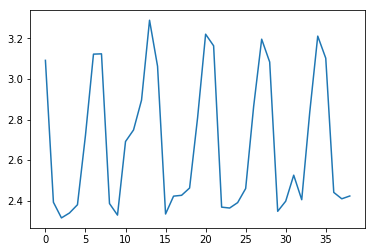

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.186852   
air_0164b9927d20bcc3_2017-04-23              1.454936   
air_0241aa3964b7f861_2017-04-23              2.238400   
air_0328696196e46f18_2017-04-23              2.168805   
air_034a3d5b40d5b1b1_2017-04-23              3.440534   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.907133  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.284209  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.378314  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.747825  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.203627

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')